# EasyOCR cyrillic train

## Imports

In [1]:
# !pip install easyocr
# !pip install natsort
# !pip install wikipedia-api
# !pip install levenshtein

In [2]:
import gc
import re
import csv
import yaml
import shutil
import random
from pathlib import Path
from tqdm.auto import tqdm

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import font_manager
from fontTools.ttLib import TTFont

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

from PIL import Image, ImageDraw, ImageFont

import torch
import torch.backends.cudnn as cudnn
from torch.utils.data import Dataset

import albumentations as A

import easyocr
from easyocr_trainer.train import train as easyocr_train
from easyocr_trainer.utils import AttrDict
import Levenshtein

import wikipediaapi

In [3]:
class Ansi:
    green = '\033[32m'
    red = '\033[31m'
    bold = '\033[1m'
    underline = '\033[4m'
    end = '\033[0m'

In [4]:
SEED = 42
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
np.random.seed(SEED)
random.seed(SEED)

# cudnn.benchmark = True
# cudnn.deterministic = False

PATH_DATASET = Path('dataset')

In [5]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
IS_CUDA = torch.cuda.is_available()
print(f'torch use: {Ansi.green}{Ansi.bold}{DEVICE}{Ansi.end}', 
      f'({torch.cuda.get_device_name()})' 
      if torch.cuda.is_available() else '')

torch use: cuda (AMD Radeon RX 7800 XT)


In [6]:
# Список допустимых символов
number = '0123456789'
symbol = "!\"#$%&'()*+,-./:;<=>?@[\\]^_`{|}~ €₽№"
lang_char = (
    'АБВГДЕЁЖЗИЙКЛМНОПРСТУФХЦЧШЩЪЫЬЭЮЯабвгдеёжзийклмнопрстуфхцчшщъыьэюя'
    # 'ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz'
)

CHARACTER = number + symbol + lang_char

## make dataset

Для обучения модели распознавания текста текста с изображений нам понадобится тренировочный и валидационный датасеты.  
Так как задача состоит в распознавании печатного текста, то тренировочные данные можно синтетически сгенерировать. В качестве источников текстовых данных используем API Википедии, откуда спарсим случайные русскоязычные статьи. Далее предобработаем полученный текст и разделим его на небольшие фрагменты, на которых будем обучать модели.

In [7]:
def fetch_wikipedia_articles(
    root_topic: list, 
    language='ru', 
    max_articles=5, 
    search_depth=3
):
    """
    Парсинг случайных статей из Википедии по заданной тематике.
    """
    wiki = wikipediaapi.Wikipedia('Wikipedia-API', language)
    articles = []  # Список текстов статей
    visited_topics = set()  # Для отслеживания уже посещённых тем
    queue_to_visit = set()  # Очередь для обхода связанных тем
    cnt_add_queue = cnt_articles = 0

    # Добавим прогрессбар
    progress_bar = tqdm(total=max_articles, desc='Articles parsing')
    while (queue_to_visit or root_topic) and cnt_articles < max_articles:
        # Сначала обходим названия статей, заданные в root_topic
        # Когда список root_topic, начинаем обход связанных статей в случайном порядке
        if root_topic:
            current_topic = root_topic.pop(0)
        else:
            current_topic = queue_to_visit.pop()

        if current_topic in visited_topics:
            continue

        # Загрузка текущей страницы
        page = wiki.page(current_topic)
        if page.exists():
            # print(f"Загружена статья: {current_topic}")
            # Разбиваем статью по переносу строки и добавляем в список
            articles.extend(page.text.split('\n'))
            visited_topics.add(current_topic)
            cnt_articles += 1

            # Добавление связанных статей в очередь
            if cnt_add_queue <= search_depth:
                links = list(page.links.keys())
                queue_to_visit.update(links)
                cnt_add_queue += 1
                
            progress_bar.update(1)

    visited_topics = list(visited_topics)
    sample_topics = np.random.choice(
        visited_topics, 
        size=min(10, len(visited_topics)), 
        replace=False
    ).tolist()

    print(f'Названия некоторых загруженых статей:', sample_topics)
    print(f'Статей загружено: {Ansi.bold}{cnt_articles}{Ansi.end}')
    return articles

In [8]:
def clean_text(texts, character):
    """
    inplace функция
    Очищает текст, оставляя только слова, состоящие из символов из списка character.
    Удаляет слова, содержащие хотя бы один символ не из списка.
    """
    valid_char_regex = re.compile(f"[{re.escape(character)}]+")
    
    for i in tqdm(range(len(texts)), desc='Text preprocessing'):
        text = texts[i]
        # Удаляем табуляции и переносы строк
        text = re.sub(r'[\n\t\r]+', ' ', text)
        # Удаляем диакритические знаки
        text = re.sub(r'[\u0300-\u036f]+', '', text)
        # Разбиваем текст на слова
        words = text.split() 
        # Оставляем только слова, которые полностью соответствуют списку символов
        valid_words = [word for word in words if valid_char_regex.fullmatch(word)]
        # Перезаписываем очищенную строку
        texts[i] = ' '.join(valid_words)

Важный момент, по умолчанию векторайзеры из sklearn отбрасывают знаки пунктуации, которые должна уметь распознавать модель. Поэтому меняем регулярное выражение в **token_pattern**, что бы сохранить пунктуацию в тексте.

In [9]:
def split_text_with_tfidf(texts, character, max_length=36, ngram_range=(2, 5)):
    """
    Разбивает текст на фразы с использованием CountVectorizer для генерации n-грамм.
    """
    # Предобработка текста
    clean_text(texts, character)

    vectorizer = CountVectorizer(
        ngram_range=ngram_range, 
        analyzer='word', 
        lowercase=False,
        # Разбиваем текст только по пробелам
        token_pattern=r"\S+",
        stop_words=None
        )
    _ = vectorizer.fit_transform(texts)
    ngrams = vectorizer.get_feature_names_out()

    # Отбираем n-граммы, которые не превышают max_length
    filtered_phrases = [
        ngram for ngram in ngrams if len(ngram) <= max_length
    ]

    return filtered_phrases

In [10]:
# Парсинг статей из Википедии
texts = fetch_wikipedia_articles(['Наука', 'Образование'], max_articles=30, search_depth=3)
print('\n')

# Предобработка текста
phrases = split_text_with_tfidf(texts, CHARACTER, max_length=38, ngram_range=(3, 9))
print(f'Сформировано различных фраз: {Ansi.bold}{len(phrases)}{Ansi.end}')

Articles parsing:   0%|          | 0/30 [00:00<?, ?it/s]

Названия некоторых загруженых статей: ['Здание', 'Образование в Мозамбике', 'Образование в Аргентине', 'Доцент', 'Образование в Гонконге', 'Образование в Черногории', 'Генетика', 'Наука', 'Информатика', 'Демография']
Статей загружено: 30




Text preprocessing:   0%|          | 0/3020 [00:00<?, ?it/s]

Сформировано различных фраз: 166141


In [11]:
print(f'{Ansi.bold}Несколько случайных фраз:{Ansi.end}')
random.choices(phrases, k=15)

Несколько случайных фраз:


['них, кто мог захватить столицу и',
 '1931. Т. 23. С. 362. 592 с.',
 'в течение, например, года у части из',
 'борт словно ненужный и',
 'пользовался незыблемым авторитетом',
 'опираются или подвешиваются поэтажно к',
 'также 0,0 18 января 1893 года. Средняя',
 'Гонконге или деятельность',
 'и Б. Н. Наумовым, а также',
 '1998 году для',
 'биологии поведение животного,',
 'к высотным. В США и',
 '1959 году в',
 'а в настоящее время известен как физик',
 'обитания и др.']

Текстовая информация получена. Далее на ее основе сгенерируем изображения и составим датасет, где каждой картинке будет соответствовать определенный текст

In [17]:
def _is_supported_chars(font_path, unicode_list):
    """
    Проверяет, поддерживает ли шрифт все нужные символы
    """
    try:
        font = TTFont(font_path)
        cmap = font['cmap'].getBestCmap()
        for code in unicode_list:
            if code not in cmap:
                return False
        return True
    except:
        return False

def get_valid_fonts(unicode_list):
    """
    Возвращает список шрифтов, поддерживающих кириллицу.
    """
    # Получаем список всех шрифтов, установленных в системе
    fonts = font_manager.findSystemFonts(fontpaths=None, fontext='ttf')  # Системные шрифты
    return [font for font in fonts if _is_supported_chars(font, unicode_list)]

In [18]:
def generate_dataset(output_dir, fonts, text_samples, img_height, max_width, num_images, transform):
    """
    Генерирует синтетический датасет.
    """
    output_dir.mkdir(parents=True, exist_ok=True)
    annotations = []
    i = 0
    
    # for i in tqdm(range(num_images), desc=f'Images generation "{PATH_DATASET.joinpath('train').name}"'):
    progress_bar = tqdm(total=num_images, desc=f'Images generation "{output_dir.name}"')
    while i < num_images:
        # Случайный текст и шрифт
        text = random.choice(text_samples)
        font_path = random.choice(fonts)
        font_size = random.randint(28, 35)
        font = ImageFont.truetype(font_path, font_size)

        # Вычисление размеров текста
        bbox = font.getbbox(text)
        text_width = bbox[2] - bbox[0]
        text_height = bbox[3] - bbox[1]
        img_width = max(text_width + 70, 100)  # Добавляем отступы

        ascent, descent = font.getmetrics()  # Метрики шрифта
        text_y_offset = (text_height - ascent) // 2  # Корректируем позицию текста

        # Если получившиеся изображение больше максимально допустимой ширины,
        # то переходим к генерации следующего
        if img_width > max_width:
            # print(text) # Для отладки
            continue
        
        # Создание изображения
        background_color = random.randint(210, 255)
        img = Image.new('L', (img_width, img_height), color=background_color)
        draw = ImageDraw.Draw(img)
        
        bbox = font.getbbox(text)
        text_width = bbox[2] - bbox[0]
        text_height = bbox[3] - bbox[1]

        # Отрисовка текста по центру
        text_x = (img_width - text_width) // 2
        text_y = (img_height - text_height) // 2 + text_y_offset - 5
        text_color = random.randint(0, 40)
        draw.text((text_x, text_y), text, fill=text_color, font=font)
        
        # Применение аугментаций
        img = np.array(img)
        img = transform(image=img)['image']
        img = Image.fromarray(img)

        # Сохранение изображения
        img_name = f"text_{i:05d}.png"
        img_path = output_dir.joinpath(img_name)
        img.save(img_path)

        # Добавление записи в аннотации
        annotations.append({"filename": img_name, "words": text})

        i += 1
        progress_bar.update(1)

    # Сохранение аннотаций в CSV
    annotations_file = output_dir.joinpath('labels.csv')
    df = pd.DataFrame(annotations)
    df.to_csv(annotations_file, index=False, encoding="utf-8")

In [19]:
# Случайные аугментации
transform = A.Compose([
    # Добавление Gaussian шума
    A.GaussNoise(var_limit=(100, 500), p=.7),

    # Добавление артефактов
    A.CoarseDropout(
        num_holes_range=(3, 7), 
        hole_height_range=(5, 10), 
        hole_width_range=(5, 10), 
        fill_value=255, 
        p=.3
    ),
        
    # Размытие
    A.GaussianBlur(blur_limit=(1, 3), p=.5),
    
    # Искажения геометрии
    A.Perspective(scale=(.01, .02), p=.5),
    
    # Изменение яркости и контраста
    A.RandomBrightnessContrast(
        brightness_limit=(-.4, .4), 
        contrast_limit=(-.4, .4), 
        p=.6
    ),
    
    # Эффект тени
    A.RandomShadow(
        num_shadows_lower=1, 
        num_shadows_upper=2, 
        shadow_intensity_range=(.8, .9), 
        p=.4
    ),
    
    # Эффект засвета
    A.RandomSunFlare(
        flare_roi=(0, 0, 1, 1), 
        angle_range=(.1, 1), 
        src_radius=60, 
        p=.25
    ),
    
    # Эффект искажения линий
    A.ElasticTransform(alpha=3, sigma=50, p=.3),
    
    ])

Получим список системных шрифтов, поддерживающих все символы, которые нам необходимо уметь распознавать. 
При генерации каждого отдельного изображения будем случайно выбирать один из доступных шрифтов. Так же для разнообразия данных будут применяться различные случайные аугментации (шум, искажения, изменение яркости и т.д), изменение размера текста и и вариации оттенков шрифта и фона.

In [20]:
# Получим список кодов unicode для всех заранее определенных символов, 
unicode_character = list(map(ord, CHARACTER))

good_fonts = get_valid_fonts(unicode_character)
print(f"Найдено подходящих шрифтов: {Ansi.bold}{len(good_fonts)}{Ansi.end}")

Найдено подходящих шрифтов: 48


В моей ОС нашлось 48 подходящих шрифтов.  
Определяем параметры изображений, размеры датасетов и генерируем картинки.

In [21]:
img_height = 32
max_width = 800
train_size = 20000
val_size = 2000
test_size = 2000

generate_dataset(PATH_DATASET.joinpath('train'), good_fonts, phrases, img_height, max_width, train_size, transform)
generate_dataset(PATH_DATASET.joinpath('val'), good_fonts, phrases, img_height, max_width, val_size, transform)
generate_dataset(PATH_DATASET.joinpath('test'), good_fonts, phrases, img_height, max_width, test_size, transform)

Images generation "train":   0%|          | 0/20000 [00:00<?, ?it/s]

Images generation "val":   0%|          | 0/2000 [00:00<?, ?it/s]

Images generation "test":   0%|          | 0/2000 [00:00<?, ?it/s]

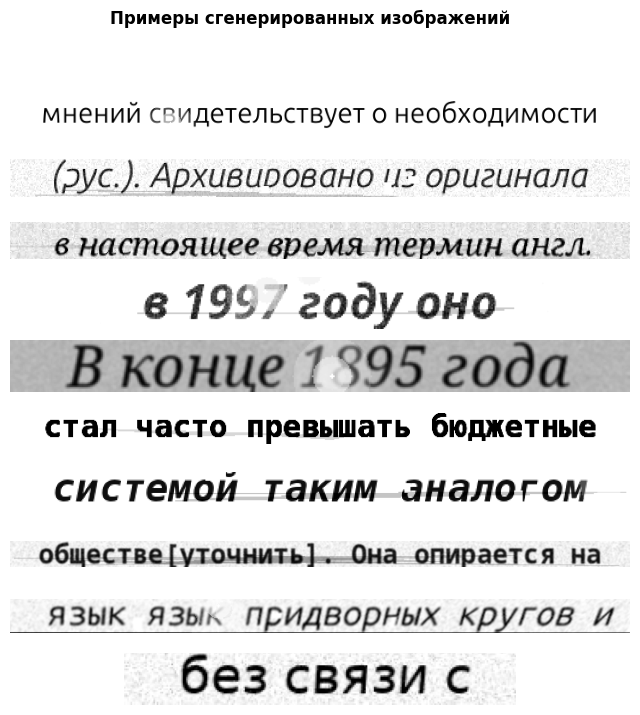

In [22]:
random_img = random.choices(list(PATH_DATASET.joinpath('train').rglob('*.png')), k=10)

fig, axes = plt.subplots(len(random_img), figsize=(8, 8))
fig.suptitle('Примеры сгенерированных изображений', fontweight='bold')
for ax, path_img in zip(axes.flat, random_img):
    img = Image.open(path_img)
    ax.imshow(img, cmap='gray')
    ax.axis('off')
plt.show()

## Base EasyOCR

Для начала определим точность предобученной модели EasyOCR в задаче распознавания кириллицы. Затем попробуем дообучить модель и повысить точность предсказаний.  
Тестировать будем на двух наборах данных. Первый - это синтетически сгенерированные строки. Второй - это несколько отсканированных страниц из первой попавшейся книги, для которой удалось нагуглить максимально совпадающие сканы страниц с текстовым представлением.  

Источники:  
- [Файл *.djvu со сканами](https://djvu.online/file/flhTayRrWUlfj)  
- [Файл *.pdf с текстом](http://русскаяшкола.рф/files/%D0%A3%D0%BF%D1%80%D0%B0%D0%B6%D0%BD%D0%B5%D0%BD%D0%B8%D1%8F_%D0%BF%D0%BE_%D0%BB%D0%BE%D0%B3%D0%B8%D0%BA%D0%B5_%D0%91%D0%BE%D0%B3%D1%83%D1%81%D0%BB%D0%B0%D0%B2%D1%81%D0%BA%D0%B8%D0%B9_1952.pdf)

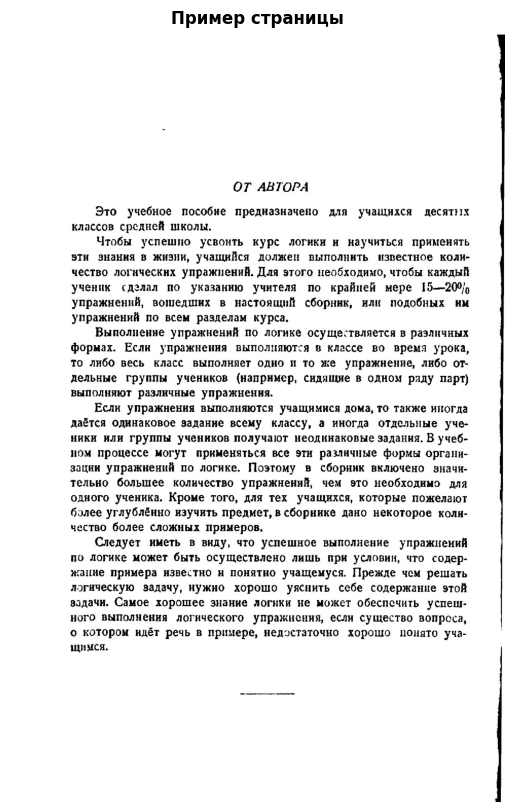

In [23]:
img = PATH_DATASET.joinpath('test_document', '01.png')
img = Image.open(img)
plt.figure(figsize=(10, 10))
plt.title('Пример страницы', fontweight='bold')
plt.imshow(img)
plt.axis('off')
plt.show()

Для удобства сделаем torch датасет.

In [24]:
class TestDataset(Dataset):
    
    def __init__(self, path):
        self.path = path
        self.labels_csv = pd.read_csv(path.joinpath('labels.csv'))

    def __len__(self):
        return len(self.labels_csv)

    def __getitem__(self, idx):
        img_name, target = self.labels_csv.iloc[idx]
        img = Image.open(self.path.joinpath(img_name)).convert('L')
        img = np.array(img)

        return img, target

# Экземпляр тестового строкового датасета
test_set_string = TestDataset(PATH_DATASET.joinpath('test'))

# Экземпляр тестового датасета с реальными фотографиями
test_set_document = TestDataset(PATH_DATASET.joinpath('test_document'))

In [25]:
# Для различных тестов
train_set_string = TestDataset(PATH_DATASET.joinpath('train'))
val_set_string = TestDataset(PATH_DATASET.joinpath('val'))

In [26]:
def calculation_score_easyocr(reader, dataset, mode='readtext'):
    """
    Расчет Levenshtein distance и Levenshtein ratio
    mode : {'readtext', 'recognize'}
    """
    match mode:
        case 'readtext':
            print(f'{Ansi.green}with detector{Ansi.end}')
        case 'recognize':
            print(f'{Ansi.red}without detector{Ansi.end}')
    
    dist_list, ratio_list = [], []
    len_target, len_output = [], []
    for img, target in tqdm(dataset):
        output = getattr(reader, mode)(img, detail=0)
        output_text = ' '.join(output)
    
        lev_dist = Levenshtein.distance(target, output_text)
        lev_ratio = 1 - (lev_dist / (len(target) + len(output_text)))

        len_target.append(len(target))
        len_output.append(len(output_text))
        
        dist_list.append(lev_dist)
        ratio_list.append(lev_ratio)

    print(
        f'{Ansi.underline}Mean length{Ansi.end}:\n'
        f'   target:  {np.mean(len_target):.2f}\n'
        f'   predict: {np.mean(len_output):.2f}\n\n'
        f'{Ansi.underline}Levenshtein{Ansi.end}:\n'
        f'   distance: {Ansi.bold}{np.mean(dist_list):.4f}{Ansi.end}\n'
        f'   ratio:    {Ansi.bold}{np.mean(ratio_list):.4f}{Ansi.end}'
    )

In [27]:
def get_predict_eacyocr(reader, dataset_elt, mode='readtext', image_size=7):
    """
    Отрисовка bboxes и получение предсказания для одного изображения
    mode : {'readtext', 'recognize'}
    """
    match mode:
        case 'readtext':
            print(f'{Ansi.green}with detector{Ansi.end}')
        case 'recognize':
            print(f'{Ansi.red}without detector{Ansi.end}')
    
    img_array, text_true = dataset_elt
    outputs = getattr(reader, mode)(img_array)
    img = Image.fromarray(img_array)
    text = []
    for output in outputs:
        box, txt, _ = output
        draw = ImageDraw.Draw(img)
        draw.polygon([tuple(cord) for cord in box], outline=0, width=2)
        text.append(txt)

    plt.figure(figsize=(image_size, image_size))
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.show()

    text_pred = " ".join(text)
    print(
        f'Ground Truth: {text_true}\n'
        f'Prediction: {text_pred}\n'
        f'{Ansi.underline}Levenshtein{Ansi.end}:\n'
        f'   distance: {Ansi.bold}{Levenshtein.distance(text_true, text_pred)}{Ansi.end}\n'
        f'   ratio:    {Ansi.bold}{Levenshtein.ratio(text_true, text_pred):.4f}{Ansi.end}'
    )

Подгрузим предобученную модель

In [28]:
reader = easyocr.Reader(
    ['ru'], 
    gpu=IS_CUDA, 
    model_storage_directory='models', 
    detect_network='craft'
)

В качестве метрики возьмем расстояние Левенштейна (*меньше-лучше*), а так же нормализованное сходство (*больше-лучше*), которое вычисляется по формуле: $1 - (distance / (len1 + len2))$

In [29]:
# Тестирование на отдельных строках
calculation_score_easyocr(reader, test_set_string)

with detector


  0%|          | 0/2000 [00:00<?, ?it/s]

/home/lake/anaconda3/envs/lime/lib/python3.11/site-packages/torch/nn/modules/linear.py:125: UserWarning: Attempting to use hipBLASLt on an unsupported architecture! Overriding blas backend to hipblas (Triggered internally at ../aten/src/ATen/Context.cpp:296.)
  return F.linear(input, self.weight, self.bias)


Mean length:
   target:  26.61
   predict: 26.03

Levenshtein:
   distance: 3.6320
   ratio:    0.9276


In [30]:
calculation_score_easyocr(reader, test_set_string, mode='recognize')

without detector


  0%|          | 0/2000 [00:00<?, ?it/s]

Mean length:
   target:  26.61
   predict: 28.80

Levenshtein:
   distance: 5.6590
   ratio:    0.8917


С включенной моделью детекции (craft) получаем точность на уровне примерно 0.93. Если отключить предварительную детекцию и подавать в recognition model изображение целиком, то точность проседает примерно на 3%.

Взглянем, как работает модель на примере одного случайного изображения.

with detector


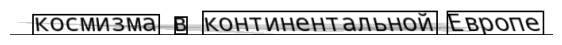

Ground Truth: космизма в континентальной Европе
Prediction: космизма В континентальной Европе
Levenshtein:
   distance: 1
   ratio:    0.9697

without detector


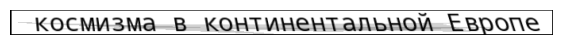

Ground Truth: космизма в континентальной Европе
Prediction: космизма В континентальной Европе
Levenshtein:
   distance: 1
   ratio:    0.9697


In [31]:
idx = np.random.choice(len(test_set_string))
elt = test_set_string[idx]

get_predict_eacyocr(reader, elt, mode='readtext')
print()
get_predict_eacyocr(reader, elt, mode='recognize')

Теперь протестируем модель на отсканированных страницах книги

In [32]:
# Тест на целых страницах
calculation_score_easyocr(reader, test_set_document)

with detector


  0%|          | 0/24 [00:00<?, ?it/s]

Mean length:
   target:  1832.88
   predict: 1810.71

Levenshtein:
   distance: 235.0417
   ratio:    0.9349


Точность на выборке из нескольких документов находится на уровне 93.5%, что на 1800 символов дает примерно 230 ошибок в среднем.  
Попробуем увеличить точность модели, дообучив ее.

## EasyOCR train

Выполним обучение той части модели, что отвечает за распознавание (recognition model). Модель детекции Craft в данном пайплайне не участвует.  
Для обучения EasyOCR необходим конфигурационный файл, и некоторые дополнительные файлы, которые есть в официальном репозитории на **[GitHub](https://github.com/JaidedAI/EasyOCR/tree/master/trainer)**. Я немного подправил код обучения, что бы он корректно работал на современных версиях библиотек, т.к. авторы несколько лет его не обновляли.  
Все файлы для обучения находятся в папке **easyocr_trainer** в данном проекте.  

Сформируем конфиг и настроим гиперпараметры.

In [33]:
def get_config_easyocr():
    
    dummy_char = 'ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyzЂђЃѓЄєІіЇїЈјЉљЊњЋћЌќЎўЏџҐґҒғҚқҮүҲҳҶҷӀӏӢӣӨөӮӯқҮүҲ'
    character = (CHARACTER + dummy_char)[:207]
    
    config = {
        'character': character,
        'experiment_name': 'easyocr_cyrillic',
        'train_data': str(PATH_DATASET),
        'valid_data': str(PATH_DATASET.joinpath('val')),
        'manualSeed': SEED,
        'workers': 2,
        'batch_size': 64, # min: 32
        'num_iter': 10000,
        'valInterval': 1000,
        'saved_model': 'models/cyrillic_g2.pth',  # pretrained model
        'FT': False,
        'optim': 'Adam', # 'adam' / 'adadelta'
        'lr': 5e-4,
        'beta1': 0.9,
        'rho': 0.95,
        'eps': 1e-08,
        'grad_clip': 5,

        #Data processing
        'select_data': 'train',  # this is dataset folder in train_data
        'batch_ratio': '1',
        'total_data_usage_ratio': 1.0,
        'batch_max_length': 38,
        'imgH': 32,
        'imgW': 800,
        'rgb': False,
        'contrast_adjust': 0.0,
        'sensitive': True,
        'PAD': True,
        'data_filtering_off': False,

        # Model Architecture
        'Transformation': 'None',
        'FeatureExtraction': 'VGG',
        'SequenceModeling': 'BiLSTM',
        'Prediction': 'CTC',
        'num_fiducial': 20,
        'input_channel': 1,
        'output_channel': 256,
        'hidden_size': 256,
        'decode': 'greedy',
        'new_prediction': False,
        'freeze_FeatureFxtraction': False,
        'freeze_SequenceModeling': False
    }

    opt = AttrDict(config)
    Path(f'./saved_models/{opt.experiment_name}').mkdir(exist_ok=True, parents=True)

    return opt

# Инициализируем конфиг для модели
opt = get_config_easyocr()

Запуск процесса обучения

In [34]:
gc.collect()
torch.cuda.empty_cache()

easyocr_train(opt, amp=False)

Filtering the images containing characters which are not in opt.character
Filtering the images whose label is longer than opt.batch_max_length
--------------------------------------------------------------------------------
dataset_root: dataset
opt.select_data: ['train']
opt.batch_ratio: ['1']
--------------------------------------------------------------------------------
dataset_root:    dataset	 dataset: train
dataset/train
sub-directory:	/train	 num samples: 19401
num total samples of train: 19401 x 1.0 (total_data_usage_ratio) = 19401
num samples of train per batch: 64 x 1.0 (batch_ratio) = 64
--------------------------------------------------------------------------------
Total_batch_size: 64 = 64
--------------------------------------------------------------------------------
dataset_root:    dataset/val	 dataset: /
dataset/val/
sub-directory:	/.	 num samples: 1952
--------------------------------------------------------------------------------
No Transformation module specifie

/home/lake/develop/ocr_projects/easyocr_trainer/train.py:177: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


training time:  195.44308304786682
[1000/10000] Train loss: 0.63574, Valid loss: 0.55269, Elapsed_time: 195.44346
Current_accuracy : 37.500, Current_norm_ED  : 0.9352
Best_accuracy    : 37.500, Best_norm_ED     : 0.9352
--------------------------------------------------------------------------------
Ground Truth              | Prediction                | Confidence Score & T/F
--------------------------------------------------------------------------------
что философия не может    | что философия не может    | 0.3461	True
"и сформулировал его концепцию, был" | и сформулировал его концепциюу был | 0.3750	False
--------------------------------------------------------------------------------
validation time:  15.779176712036133
training time:  195.44855165481567
[2000/10000] Train loss: 0.44535, Valid loss: 0.38123, Elapsed_time: 406.67133
Current_accuracy : 41.086, Current_norm_ED  : 0.9421
Best_accuracy    : 41.086, Best_norm_ED     : 0.9421
--------------------------------------------

Обучение корректно завершилось. loss на трейне и метрики на тесте от эпохи к эпохе снижались. Модель можно продолжать обучать дальше, минимум функции потерь еще (скорее всего) далеко, вопрос только во времени.

Для того, что бы засунуть обученные веса в модель EasyOCR, нужно провести еще кое-какие манипуляции. Скопируем файл с лучшими весами модели в папку custom_easyocr, куда еще необходимо докачать *.py файл, а так же еще один конфигурационный файл (оригинальные файлы и инструкция лежат в репозитории на [GitHub](https://github.com/JaidedAI/EasyOCR/blob/master/custom_model.md))

In [35]:
custom_easyocr = 'custom_easyocr'

# Копируем в папку custom_easyocr  и переименовываем файл с лучшими весами модели
shutil.copy(
    Path('saved_models/easyocr_cyrillic/best_norm_ED.pth'),
    Path(custom_easyocr)
)

# Переименовываем скопированный файл
Path(custom_easyocr, 'best_norm_ED.pth').rename(Path(custom_easyocr, custom_easyocr + '.pth'))

PosixPath('custom_easyocr/custom_easyocr.pth')

In [36]:
# Конфиг для тренированной модели
def get_train_config_easyocr(opt, path):

    config = {
        'network_params': {
            'input_channel': opt.input_channel,
            'output_channel': opt.output_channel,
            'hidden_size': opt.hidden_size
        },
        'imgH': opt.imgH,
        'lang_list': ['ru'],
        'character_list': opt.character
    }
    
    with open(Path(path, path + '.yaml'), 'w', encoding='utf-8') as file:
        yaml.dump(config, file, allow_unicode=True)


get_train_config_easyocr(opt, custom_easyocr)

Загружаем новые веса в модель

In [37]:
reader_custom = easyocr.Reader(
    ['ru'],
    gpu=IS_CUDA,
    detect_network='craft',
    model_storage_directory=custom_easyocr,
    user_network_directory=custom_easyocr,
    recog_network=custom_easyocr
)

In [38]:
# Тестирование на отдельных строках
calculation_score_easyocr(reader_custom, val_set_string)

with detector


  0%|          | 0/2000 [00:00<?, ?it/s]

Mean length:
   target:  26.79
   predict: 26.46

Levenshtein:
   distance: 1.0135
   ratio:    0.9790


In [39]:
# Тестирование на отдельных строках
calculation_score_easyocr(reader_custom, val_set_string, mode='recognize')

without detector


  0%|          | 0/2000 [00:00<?, ?it/s]

Mean length:
   target:  26.79
   predict: 26.80

Levenshtein:
   distance: 0.6295
   ratio:    0.9879


Метрика неплохо так выросла по сравнению с моделью до нашего обучения. Сейчас точность с детектором **98%** а без детектора почти **99%** (а было 93% и 89% соответственно).

То что в этот раз получилась противоположная ситуация и скор без детектора выше, чем с ним, я предположительно объясняю несовершенством нашего алгоритма генерации изображений для обучения. Дело в том, что Craft обрезает слова контуру (в выделенном прямоугольнике остается мало незаполненного пространства), в то время как на наших тренировочных изображениях в среднем остается больше пустого пространства, и модель лучше затачивается под картинки, где текст имеет большие отступы.

with detector


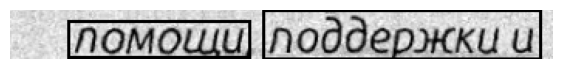

Ground Truth: помощи, поддержки и
Prediction: помощи поддержки и
Levenshtein:
   distance: 1
   ratio:    0.9730

without detector


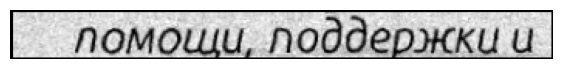

Ground Truth: помощи, поддержки и
Prediction: помощи, поддержки и
Levenshtein:
   distance: 0
   ratio:    1.0000


In [43]:
idx = np.random.choice(len(test_set_string))
elt = test_set_string[idx]

get_predict_eacyocr(reader_custom, elt, mode='readtext')
print()
get_predict_eacyocr(reader_custom, elt, mode='recognize')

Взглянем, как обученная модель справится с отсканированными документами.

In [41]:
# Тест на целых страницах
calculation_score_easyocr(reader_custom, test_set_document)

with detector


  0%|          | 0/24 [00:00<?, ?it/s]

Mean length:
   target:  1832.88
   predict: 1779.17

Levenshtein:
   distance: 184.4583
   ratio:    0.9482


Точность модели на этом датасете возросла, и сейчас равняется - **94.8%** (до обучения было **93.5%**). Что на среднем тексте в 1800 символов сократило число ошибок примерно на 50. Это все еще далеко до идеала, но главное, удалось улучшить результат.

Взглянем на конкретный пример работы модели на большом тексте.

with detector


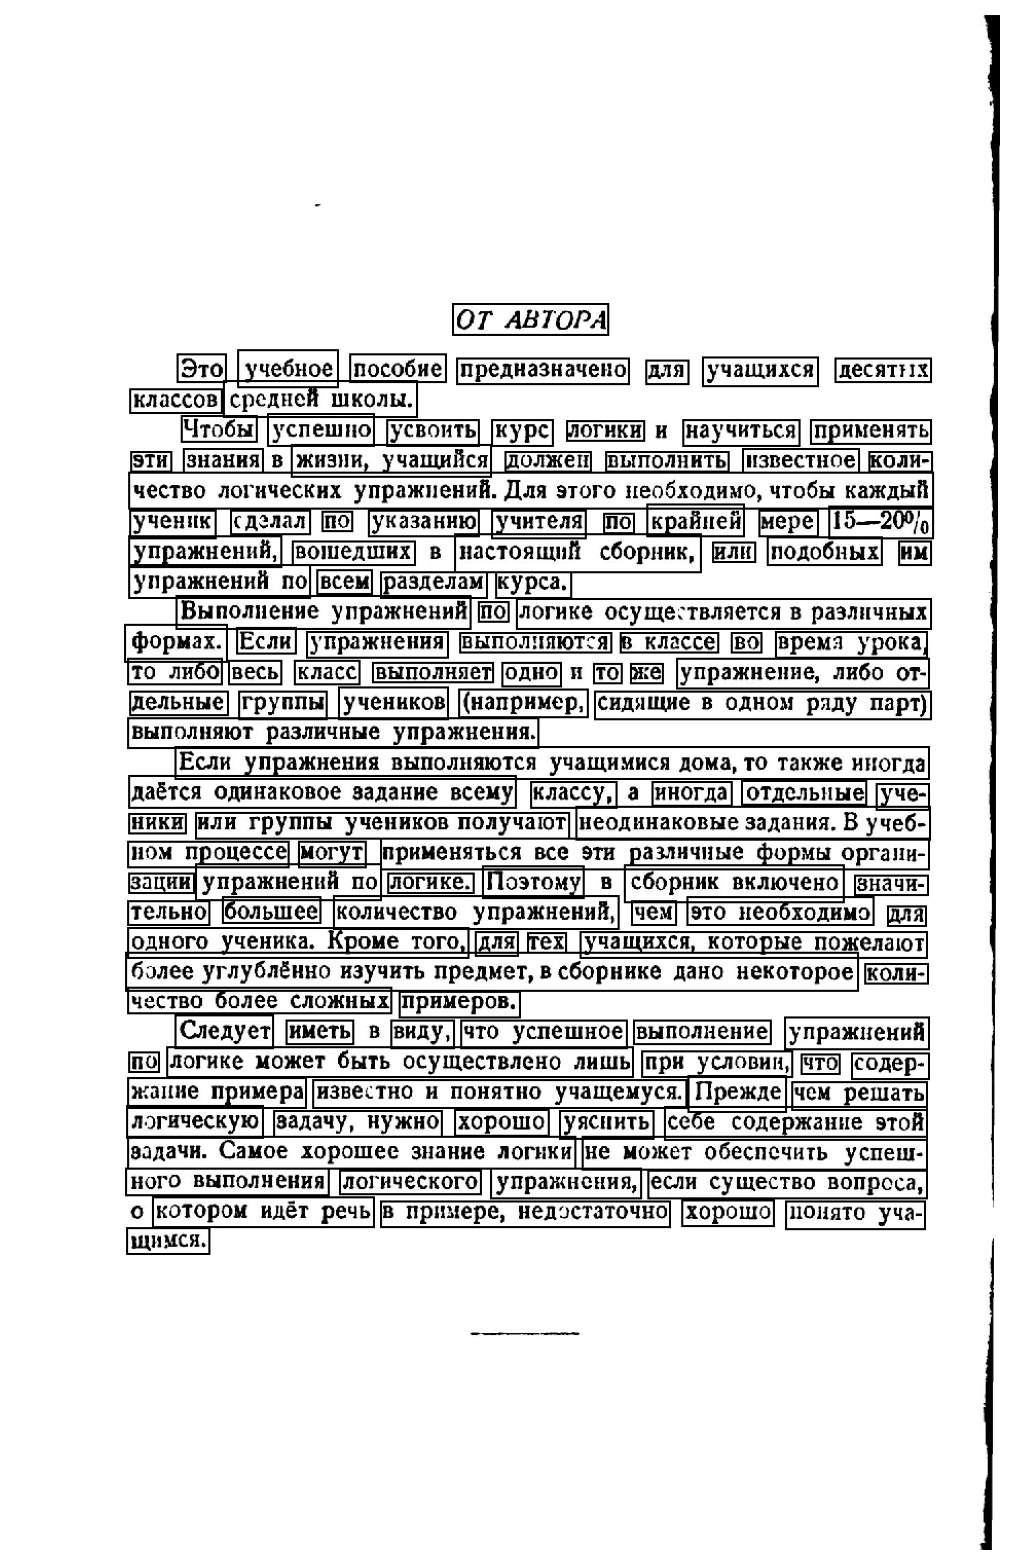

Ground Truth: ОТ АВТОРА Это учебное пособие предназначено для учащихся десятых классов средней школы. Чтобы успешно усвоить курс логики и научиться приме- нять эти знания в жизни, учащийся должен выполнить извест- ное количество логических упражнений. Для этого необходимо, чтобы каждый ученик сделал по указанию учителя, по край- ней мере, 15—20% упражнений, вошедших в настоящий сбор- ник, или подобных им упражнений по всем разделам курса. Выполнение упражнений по логике осуществляется в раз- личных формах. Если упражнения выполняются в классе во вре- мя урока, то либо весь класс выполняет одно и то же упражне- ние, либо отдельные группы учеников (например, сидящие в одном ряду парт) выполняют различные упражнения. Если упражнения выполняются учащимися дома, то также иногда даётся одинаковое задание всему классу, а иногда отдель- ные ученики или группы учеников получают неодинаковые зада- ния. В учебном процессе могут применяться все эти различные формы организации упражнений по логике.

In [42]:
get_predict_eacyocr(reader_custom, test_set_document[0], image_size=20)

Модель детекции с данным изображением справилась довольно хорошо, хотя есть некоторые пропуски отдельно стоящих букв.

Модель распознавания можно улучшить следующими способами:
- добавить в обучающую выборку изображения с похожим шрифтом.
- доработать генерацию синтетических данных, что бы на отдельных изображениях оставалось как можно меньше пустого пространства.
- добавить больше аугментаций, в частности наклон изображения, который я пока убрал, так как с ним текст на многих изображениях сильно обрезался.